# Modelo de Riesgo de Crédito

## Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
df = pd.read_csv(os.path.join('..', 'data', 'output', 'loan_cleaned.csv'))

X = df.drop("target", axis=1)
y = df["target"]

# Identificar columnas por tipo, excluyendo el target
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

In [ ]:
# # Realizar undersampling
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=42)
# X_res, y_res = rus.fit_resample(X, y)

In [140]:
# Realizar oversampling con SMOTENC
from imblearn.over_sampling import SMOTENC
smote = SMOTENC(categorical_features=[X.columns.get_loc(col) for col in cat_cols], random_state=42)
X_res, y_res = smote.fit_resample(X, y)

In [143]:
y_res.value_counts()

target
0    148065
1    148065
Name: count, dtype: int64

In [144]:
# Definir transformadores
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Crear preprocesador solo para features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    verbose_feature_names_out=False
)

# Crear pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# Ajustar y transformar solo los features
X_transformed = pd.DataFrame(
    pipeline.fit_transform(X_res),
    columns=pipeline.get_feature_names_out(),
    index=X_res.index
)

In [145]:
X_transformed

,annual_inc,zip_code,dti,open_acc,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,-0.557943,1.100506,-0.152474,-0.953553,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.820750,-0.637357,0.881776,-1.382058,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.435380,1.334753,0.062660,0.760468,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.493283,-0.096055,0.547716,0.546216,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.458242,-1.286285,-1.594278,0.974721,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296125,0.931293,-1.381251,-0.852981,-0.115749,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296126,-0.277598,1.315760,-0.796292,-0.443487,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296127,-0.645545,-1.330603,-0.278655,-0.091678,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
296128,-0.487861,-1.346430,0.721717,-0.054749,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
y_res

0         0
1         0
2         0
3         0
4         0
         ..
296125    1
296126    1
296127    1
296128    1
296129    1
Name: target, Length: 296130, dtype: int64

In [147]:
# Guardar el pipeline para uso posterior
import joblib
joblib.dump(pipeline, os.path.join('..', 'models', 'preprocessor.pkl'))

['..\\models\\preprocessor.pkl']

In [148]:
# Dividir en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y_res, test_size=0.2, random_state=42)

In [149]:
def find_optimal_threshold(y_true, y_pred_proba):
    """
    Encuentra el threshold óptimo basado en f1 score.
    """
    # Calcular precision-recall para diferentes thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    
    # Calcular F1 para cada threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    
    # Encontrar el threshold óptimo
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    
    return optimal_threshold

In [150]:
# Visualizar la curva ROC y PR
def plot_threshold_curves(y_true, y_pred_proba, optimal_threshold):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Curva ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ax1.plot(fpr, tpr)
    ax1.plot([0, 1], [0, 1], '--')
    ax1.set_title('Curva ROC')
    ax1.set_xlabel('Tasa de Falsos Positivos')
    ax1.set_ylabel('Tasa de Verdaderos Positivos')
    
    # Curva Precision-Recall
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred_proba)
    ax2.plot(recalls, precisions)
    ax2.axvline(x=recalls[np.argmin(np.abs(thresholds - optimal_threshold))], 
                color='r', linestyle='--', label=f'Threshold óptimo: {optimal_threshold:.3f}')
    ax2.set_title('Curva Precision-Recall')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

In [151]:
def predict_with_optimal_threshold(model, X, threshold):
    """
    Realiza predicciones usando el threshold optimizado
    """
    y_pred_proba = model.predict(X)
    return (y_pred_proba >= threshold).astype(int)

## Primer modelo

In [152]:
# Model Checkpoint ajustado
checkpoint = ModelCheckpoint(
    os.path.join('..', 'models', 'loan_model_1.h5'),
    monitor='val_f1_score',  # Cambiado para coincidir con el nombre de la métrica
    mode='max',
    save_best_only=True,
    restore_best_weights=True,
    verbose=1
)

# Definir el modelo
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo con F1Score de tensorflow_addons
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        tfa.metrics.F1Score(
            num_classes=1,
            average='micro',  # Especificamos 'micro' para clasificación binaria
            name='f1_score'  # Este nombre se usará con prefijo 'val_' en validación
        )
    ]
)

In [153]:
# Entrenar el modelo
history = model.fit(X_train, y_train, 
	validation_split=0.2,
	epochs=50, 
	batch_size=2048, 
	callbacks=[checkpoint],
	verbose=1
)


Epoch 1/50
87/93 [===========================>..] - ETA: 0s - loss: 0.6664 - f1_score: 0.6672
Epoch 1: val_f1_score improved from -inf to 0.66403, saving model to ..\models\loan_model_1.h5
93/93 [==============================] - 1s 7ms/step - loss: 0.6658 - f1_score: 0.6672 - val_loss: 0.6504 - val_f1_score: 0.6640
Epoch 2/50
21/93 [=====>........................] - ETA: 0s - loss: 0.6528 - f1_score: 0.6651

d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_2\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


89/93 [===========================>..] - ETA: 0s - loss: 0.6540 - f1_score: 0.6674
Epoch 2: val_f1_score did not improve from 0.66403
93/93 [==============================] - 1s 6ms/step - loss: 0.6539 - f1_score: 0.6672 - val_loss: 0.6464 - val_f1_score: 0.6640
Epoch 3/50
89/93 [===========================>..] - ETA: 0s - loss: 0.6511 - f1_score: 0.6673
Epoch 3: val_f1_score did not improve from 0.66403
93/93 [==============================] - 0s 5ms/step - loss: 0.6509 - f1_score: 0.6672 - val_loss: 0.6451 - val_f1_score: 0.6640
Epoch 4/50
90/93 [============================>.] - ETA: 0s - loss: 0.6489 - f1_score: 0.6673
Epoch 4: val_f1_score did not improve from 0.66403
93/93 [==============================] - 1s 5ms/step - loss: 0.6492 - f1_score: 0.6672 - val_loss: 0.6445 - val_f1_score: 0.6640
Epoch 5/50
86/93 [==========================>...] - ETA: 0s - loss: 0.6481 - f1_score: 0.6672
Epoch 5: val_f1_score did not improve from 0.66403
93/93 [==============================] - 0s 

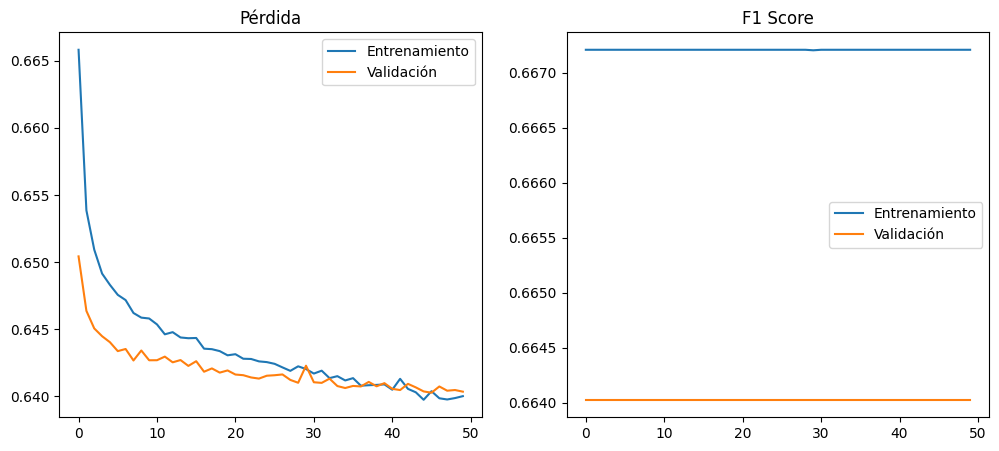

In [154]:
# Plot de la pérdida y F1 Score
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# F1 Score
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Entrenamiento')
plt.plot(history.history['val_f1_score'], label='Validación')
plt.title('F1 Score')
plt.legend()

plt.show()

In [155]:
# Evaluar el modelo
y_pred_proba = model.predict(X_test).ravel()

1851/1851 [==============================] - 1s 575us/step


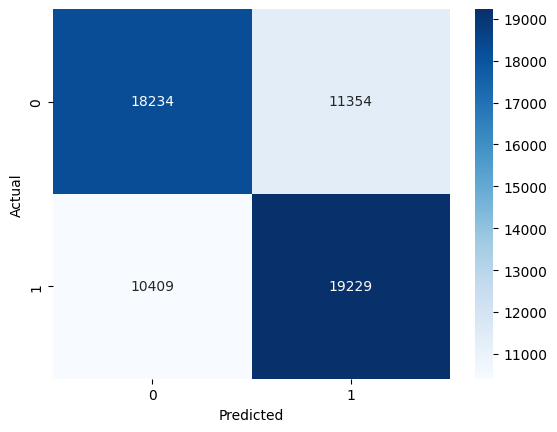

In [156]:
# Matriz de confusión
y_pred = (y_pred_proba > 0.5).astype(int)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [157]:
# Reporte de clasificación
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.62      0.63     29588
           1       0.63      0.65      0.64     29638

    accuracy                           0.63     59226
   macro avg       0.63      0.63      0.63     59226
weighted avg       0.63      0.63      0.63     59226



In [158]:
# Encontrar threshold óptimo
optimal_threshold = find_optimal_threshold(y_test, y_pred_proba)

print(f"Threshold óptimo: {optimal_threshold:.3f}")

# Aplicar el threshold óptimo
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# Evaluar con el nuevo threshold
f1_optimal = f1_score(y_test, y_pred_optimal)
print(f"F1-Score con threshold óptimo: {f1_optimal:.3f}")

Threshold óptimo: 0.346
F1-Score con threshold óptimo: 0.691


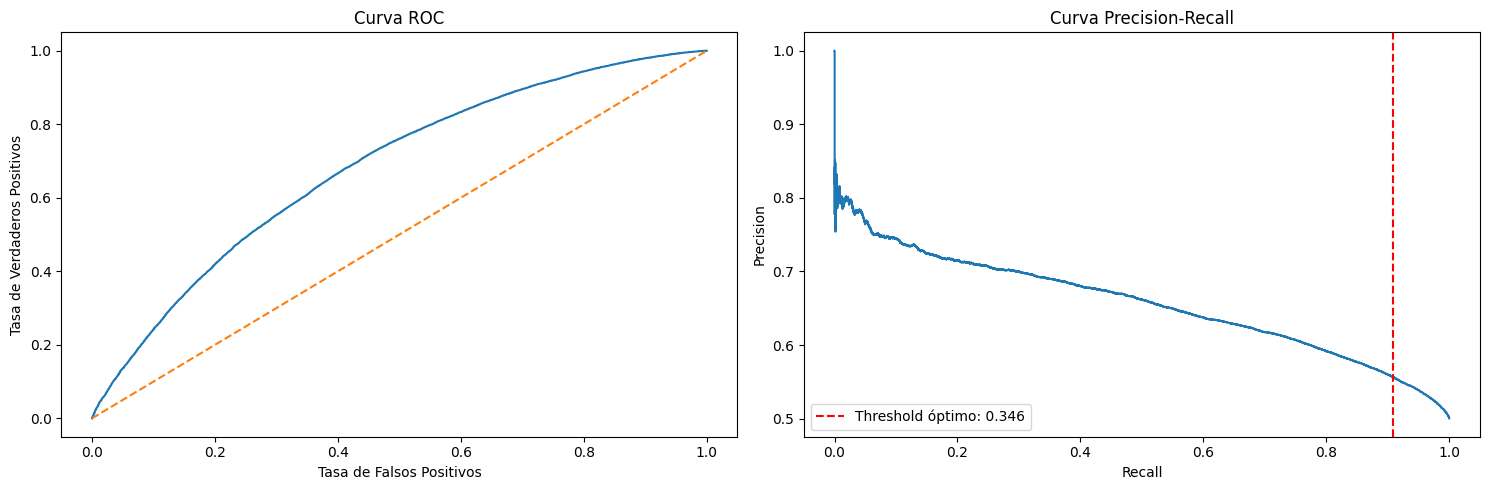

In [159]:
plot_threshold_curves(y_test, y_pred_proba, optimal_threshold)

In [160]:
# Usar en nuevos datos
y_pred = predict_with_optimal_threshold(model, X_test, optimal_threshold)

print(classification_report(y_test, y_pred))

1851/1851 [==============================] - 1s 612us/step
              precision    recall  f1-score   support

           0       0.75      0.28      0.40     29588
           1       0.56      0.91      0.69     29638

    accuracy                           0.59     59226
   macro avg       0.65      0.59      0.55     59226
weighted avg       0.65      0.59      0.55     59226



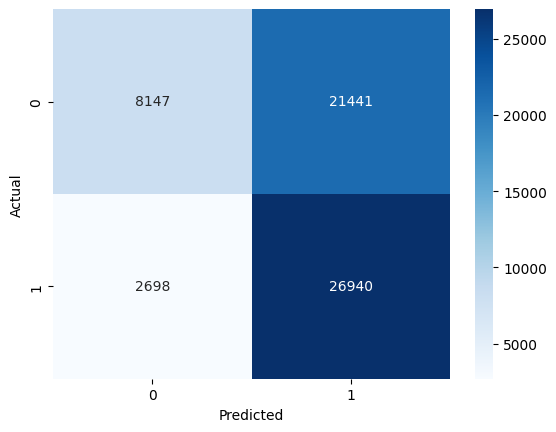

In [161]:
confusion_matrix = pd.crosstab(y_test, y_pred.flatten(), rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

## Segundo modelo

In [162]:
# Model Checkpoint ajustado
checkpoint = ModelCheckpoint(
    os.path.join('..', 'models', 'loan_model_2.h5'),
    monitor='val_f1_score',  # Cambiado para coincidir con el nombre de la métrica
    mode='max',
    save_best_only=True,
    restore_best_weights=True,
    verbose=1
)

# Definir el modelo mejorado
model2 = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),  # Primera capa
    BatchNormalization(),
    Dropout(0.4),
    
    Dense(128, activation='relu'),  # Segunda capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(64, activation='relu'),  # Tercera capa
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(32, activation='relu'),  # Cuarta capa
    Dropout(0.2),
    
    Dense(1, activation='sigmoid')  # Capa de salida
])

# Compilar el modelo con F1Score de tensorflow_addons
model2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[
        tfa.metrics.F1Score(
            num_classes=1,
            average='micro',  # Especificamos 'micro' para clasificación binaria
            name='f1_score'  # Este nombre se usará con prefijo 'val_' en validación
        )
    ]
)

In [163]:
# Entrenar el modelo
history2 = model2.fit(X_train, y_train, 
	validation_split=0.2,
	epochs=50, 
	batch_size=2048, 
	callbacks=[checkpoint],
	verbose=1
)

Epoch 1/50
91/93 [============================>.] - ETA: 0s - loss: 0.7427 - f1_score: 0.6673
Epoch 1: val_f1_score improved from -inf to 0.66403, saving model to ..\models\loan_model_2.h5
93/93 [==============================] - 3s 19ms/step - loss: 0.7419 - f1_score: 0.6672 - val_loss: 0.6762 - val_f1_score: 0.6640
Epoch 2/50
 5/93 [>.............................] - ETA: 1s - loss: 0.6900 - f1_score: 0.6673

d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_2\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


90/93 [============================>.] - ETA: 0s - loss: 0.6796 - f1_score: 0.6674
Epoch 2: val_f1_score did not improve from 0.66403
93/93 [==============================] - 2s 16ms/step - loss: 0.6795 - f1_score: 0.6672 - val_loss: 0.6713 - val_f1_score: 0.6640
Epoch 3/50
91/93 [============================>.] - ETA: 0s - loss: 0.6663 - f1_score: 0.6673
Epoch 3: val_f1_score did not improve from 0.66403
93/93 [==============================] - 1s 16ms/step - loss: 0.6663 - f1_score: 0.6672 - val_loss: 0.6589 - val_f1_score: 0.6640
Epoch 4/50
90/93 [============================>.] - ETA: 0s - loss: 0.6603 - f1_score: 0.6671
Epoch 4: val_f1_score did not improve from 0.66403
93/93 [==============================] - 1s 16ms/step - loss: 0.6603 - f1_score: 0.6672 - val_loss: 0.6539 - val_f1_score: 0.6640
Epoch 5/50
91/93 [============================>.] - ETA: 0s - loss: 0.6561 - f1_score: 0.6671
Epoch 5: val_f1_score did not improve from 0.66403
93/93 [==============================] - 

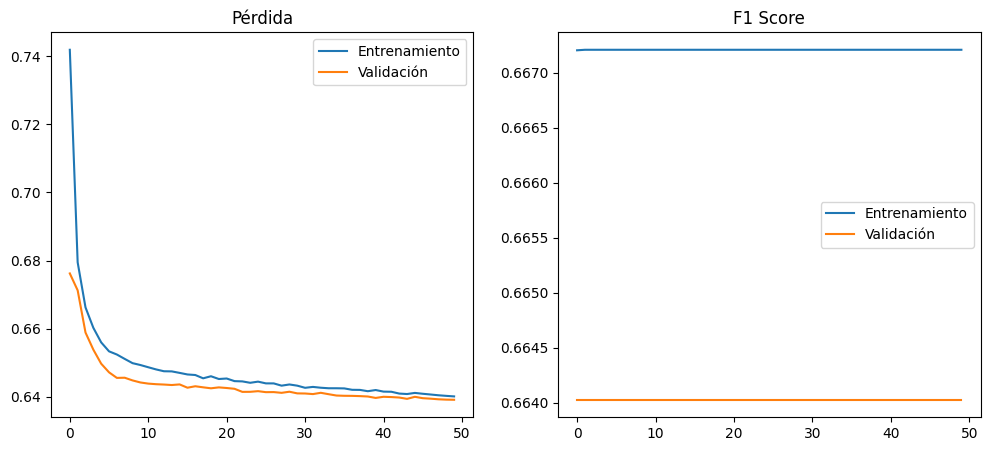

In [164]:
# Plot de la pérdida y F1 Score
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Entrenamiento')
plt.plot(history2.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# F1 Score
plt.subplot(1, 2, 2)
plt.plot(history2.history['f1_score'], label='Entrenamiento')
plt.plot(history2.history['val_f1_score'], label='Validación')
plt.title('F1 Score')
plt.legend()

plt.show()

In [165]:
# Evaluar el modelo
y_pred_proba2 = model2.predict(X_test).ravel()
y_pred2 = (y_pred_proba2 > 0.5).astype(int)

1851/1851 [==============================] - 2s 843us/step


Predicted      0      1
Actual                 
0          17227  12361
1           9314  20324


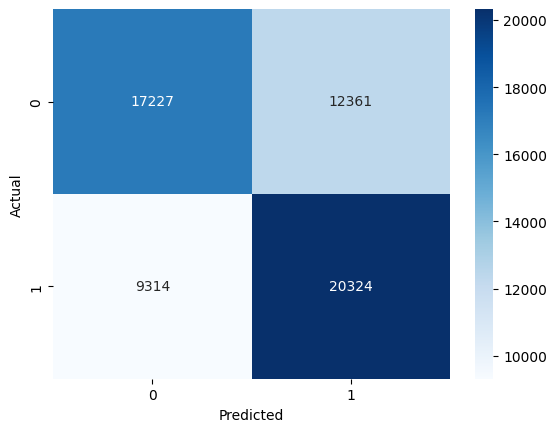

In [166]:
# Matriz de confusión
confusion_matrix = pd.crosstab(y_test, y_pred2, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [167]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.65      0.58      0.61     29588
           1       0.62      0.69      0.65     29638

    accuracy                           0.63     59226
   macro avg       0.64      0.63      0.63     59226
weighted avg       0.64      0.63      0.63     59226



In [168]:
# Encontrar threshold óptimo
optimal_threshold = find_optimal_threshold(y_test, y_pred_proba2)

print(f"Threshold óptimo: {optimal_threshold:.3f}")

# Aplicar el threshold óptimo
y_pred_optimal2 = (y_pred_proba2 >= optimal_threshold).astype(int)

# Evaluar con el nuevo threshold
f1_optimal = f1_score(y_test, y_pred_optimal2)
print(f"F1-Score con threshold óptimo: {f1_optimal:.3f}")


Threshold óptimo: 0.355
F1-Score con threshold óptimo: 0.691


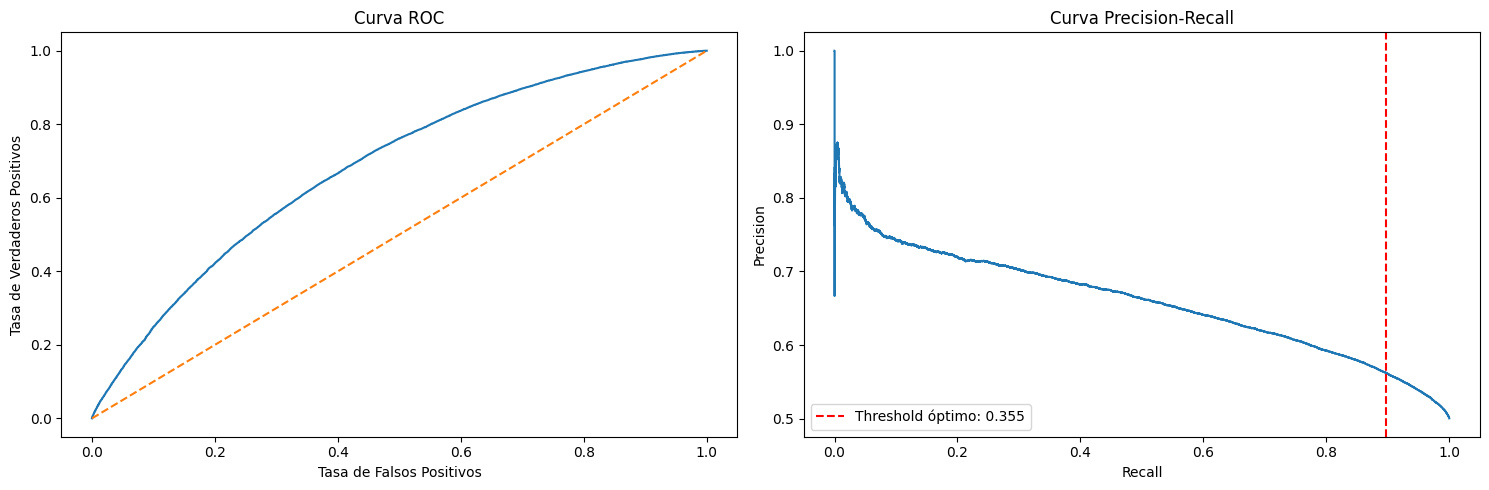

In [169]:
plot_threshold_curves(y_test, y_pred_proba2, optimal_threshold)

In [170]:
# Usar en nuevos datos
y_pred2 = predict_with_optimal_threshold(model2, X_test, optimal_threshold)

print(classification_report(y_test, y_pred2))

1851/1851 [==============================] - 2s 821us/step
              precision    recall  f1-score   support

           0       0.75      0.30      0.43     29588
           1       0.56      0.90      0.69     29638

    accuracy                           0.60     59226
   macro avg       0.65      0.60      0.56     59226
weighted avg       0.65      0.60      0.56     59226



Predicted     0      1
Actual                
0          8867  20721
1          3033  26605


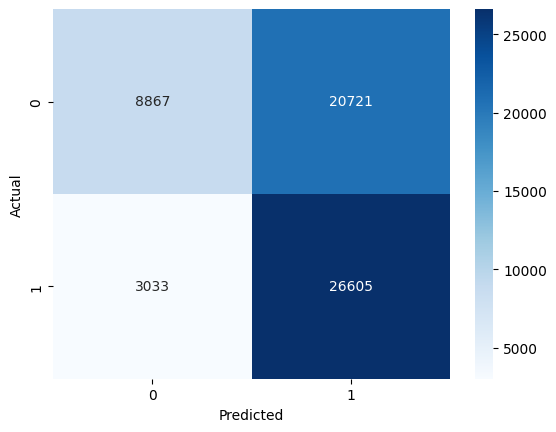

In [171]:
confusion_matrix = pd.crosstab(y_test, y_pred2.flatten(), rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

## Tercer modelo

In [172]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Definir bloque residual como una capa personalizada
class ResidualBlock(Layer):
    def __init__(self, units, dropout_rate=0.3, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        self.units = units
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        self.dense = Dense(
            self.units, 
            kernel_initializer=HeNormal(),
            kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)
        )
        self.bn = BatchNormalization()
        self.activation = Activation('relu')
        self.dropout = Dropout(self.dropout_rate)
        self.shortcut = Dense(self.units) if input_shape[-1] != self.units else None
        self.add = Add()
        
    def call(self, inputs, training=None):
        x = self.dense(inputs)
        x = self.bn(x, training=training)
        x = self.activation(x)
        x = self.dropout(x, training=training)
        
        shortcut = self.shortcut(inputs) if self.shortcut is not None else inputs
        return self.add([x, shortcut])

In [173]:
# Model Checkpoint ajustado
checkpoint = ModelCheckpoint(
    os.path.join('..', 'models', 'loan_model_3.h5'),
    monitor='val_f1_score',  # Cambiado para coincidir con el nombre de la métrica
    mode='max',
    save_best_only=True,
    restore_best_weights=True,
    verbose=1
)

# Definir el modelo mejorado
model3 = Sequential([
    # Capa de entrada
    Dense(512, input_dim=X_train.shape[1], 
          kernel_initializer=HeNormal(),
          kernel_regularizer=l1_l2(l1=0.0001, l2=0.001)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    
    # Bloques residuales
    ResidualBlock(256, dropout_rate=0.4),
    ResidualBlock(128, dropout_rate=0.3),
    ResidualBlock(64, dropout_rate=0.2),
    
    # Capa de salida
    Dense(1, activation='sigmoid', 
          kernel_initializer=HeNormal(),
          kernel_regularizer=l1_l2(l1=0.0001, l2=0.001))
])

# Compilar el modelo con F1Score de tensorflow_addons
model3.compile(
    optimizer=Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=True
    ),
    loss='binary_crossentropy',
    metrics=[
        tfa.metrics.F1Score(
            num_classes=1,
            average='micro',  # Especificamos 'micro' para clasificación binaria
            name='f1_score'  # Este nombre se usará con prefijo 'val_' en validación
        ),
        "AUC"
    ]
)

In [174]:
# Entrenar el modelo
history3 = model3.fit(X_train, y_train, 
	validation_split=0.2,
	epochs=50, 
	batch_size=2048, 
	callbacks=[checkpoint, ReduceLROnPlateau(
            monitor='val_auc',
            factor=0.5,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),],
	verbose=1
)

Epoch 1/50
92/93 [============================>.] - ETA: 0s - loss: 3.3730 - f1_score: 0.6672 - auc: 0.5946
Epoch 1: val_f1_score improved from -inf to 0.66403, saving model to ..\models\loan_model_3.h5
93/93 [==============================] - 5s 40ms/step - loss: 3.3684 - f1_score: 0.6672 - auc: 0.5947 - val_loss: 2.5481 - val_f1_score: 0.6640 - val_auc: 0.6550 - lr: 0.0010
Epoch 2/50
 3/93 [..............................] - ETA: 3s - loss: 2.5594 - f1_score: 0.6678 - auc: 0.6212

d:\PREGRADO INGENIERÍA DE SISTEMAS E INFORMÁTICA\2024-2. Redes Neuronales\trabajo_2\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


93/93 [==============================] - ETA: 0s - loss: 2.0766 - f1_score: 0.6672 - auc: 0.6268
Epoch 2: val_f1_score did not improve from 0.66403
93/93 [==============================] - 3s 37ms/step - loss: 2.0766 - f1_score: 0.6672 - auc: 0.6268 - val_loss: 1.6413 - val_f1_score: 0.6640 - val_auc: 0.6664 - lr: 0.0010
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 1.4073 - f1_score: 0.6672 - auc: 0.6369
Epoch 3: val_f1_score did not improve from 0.66403
93/93 [==============================] - 3s 37ms/step - loss: 1.4073 - f1_score: 0.6672 - auc: 0.6369 - val_loss: 1.1914 - val_f1_score: 0.6640 - val_auc: 0.6648 - lr: 0.0010
Epoch 4/50
92/93 [============================>.] - ETA: 0s - loss: 1.0805 - f1_score: 0.6672 - auc: 0.6418
Epoch 4: val_f1_score did not improve from 0.66403
93/93 [==============================] - 3s 38ms/step - loss: 1.0800 - f1_score: 0.6672 - auc: 0.6417 - val_loss: 0.9785 - val_f1_score: 0.6640 - val_auc: 0.6543 - lr: 0.0010
Epoch 5/5

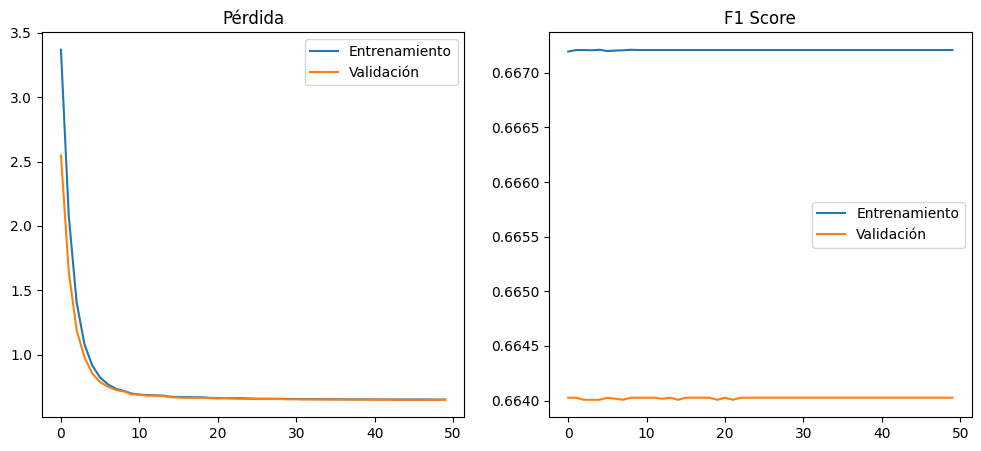

In [175]:
# Plot de la pérdida y F1 Score
plt.figure(figsize=(12, 5))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history3.history['loss'], label='Entrenamiento')
plt.plot(history3.history['val_loss'], label='Validación')
plt.title('Pérdida')
plt.legend()

# F1 Score
plt.subplot(1, 2, 2)
plt.plot(history3.history['f1_score'], label='Entrenamiento')
plt.plot(history3.history['val_f1_score'], label='Validación')
plt.title('F1 Score')
plt.legend()

plt.show()

In [176]:
# Evaluar el modelo
y_pred_proba3 = model3.predict(X_test).ravel()
y_pred3 = (y_pred_proba3 > 0.5).astype(int)

1851/1851 [==============================] - 3s 2ms/step


Predicted      0      1
Actual                 
0          17132  12456
1           9483  20155


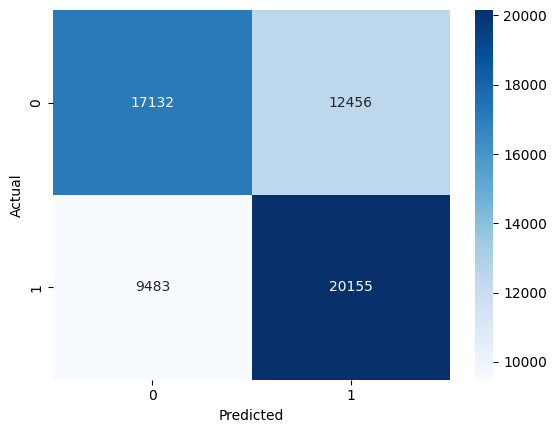

In [177]:
# Matriz de confusión
confusion_matrix = pd.crosstab(y_test, y_pred3, rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

In [178]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61     29588
           1       0.62      0.68      0.65     29638

    accuracy                           0.63     59226
   macro avg       0.63      0.63      0.63     59226
weighted avg       0.63      0.63      0.63     59226



In [179]:
# Encontrar threshold óptimo
optimal_threshold = find_optimal_threshold(y_test, y_pred_proba3)

print(f"Threshold óptimo: {optimal_threshold:.3f}")

# Aplicar el threshold óptimo
y_pred_optimal3 = (y_pred_proba3 >= optimal_threshold).astype(int)

# Evaluar con el nuevo threshold
f1_optimal = f1_score(y_test, y_pred_optimal3)
print(f"F1-Score con threshold óptimo: {f1_optimal:.3f}")


Threshold óptimo: 0.362
F1-Score con threshold óptimo: 0.689


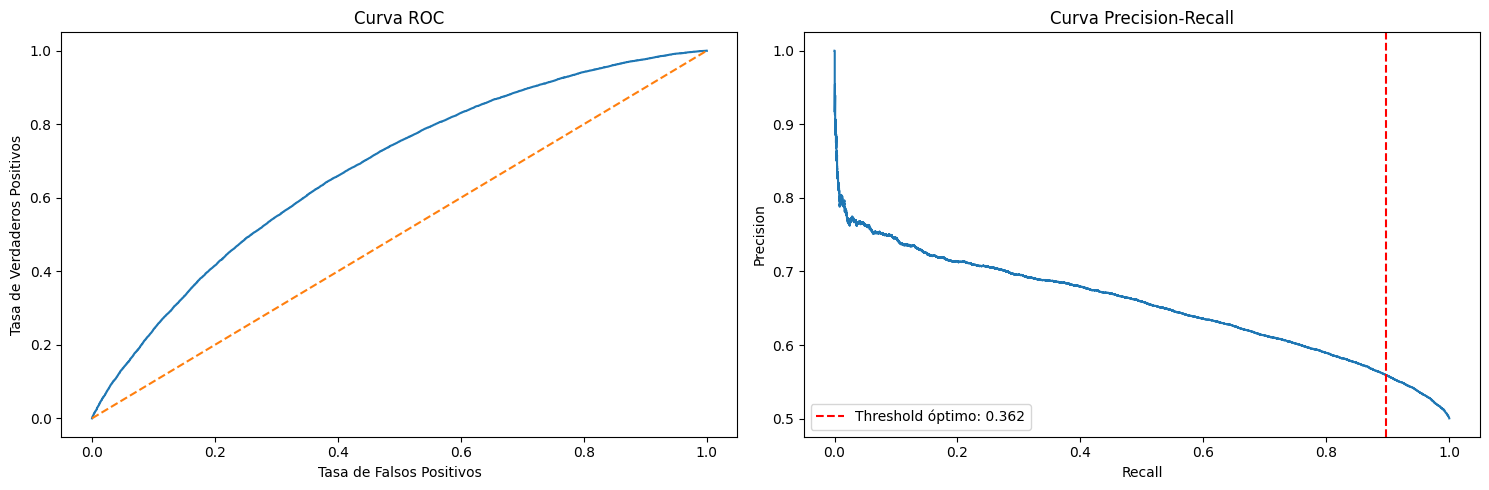

In [180]:
plot_threshold_curves(y_test, y_pred_proba3, optimal_threshold)

In [181]:
# Usar en nuevos datos
y_pred3 = predict_with_optimal_threshold(model3, X_test, optimal_threshold)

print(classification_report(y_test, y_pred3))

1851/1851 [==============================] - 3s 2ms/step
              precision    recall  f1-score   support

           0       0.74      0.29      0.42     29588
           1       0.56      0.90      0.69     29638

    accuracy                           0.59     59226
   macro avg       0.65      0.59      0.55     59226
weighted avg       0.65      0.59      0.55     59226



Predicted     0      1
Actual                
0          8634  20954
1          3038  26600


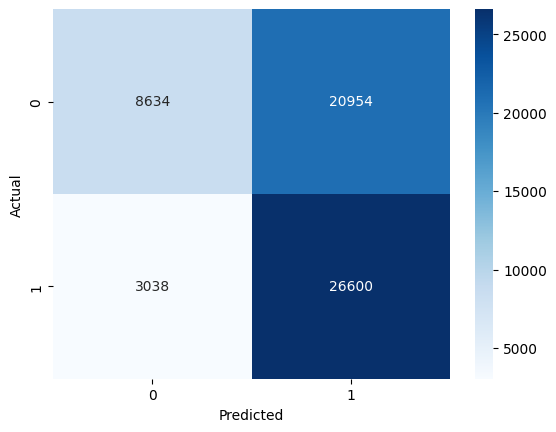

In [182]:
confusion_matrix = pd.crosstab(y_test, y_pred3.flatten(), rownames=['Actual'], colnames=['Predicted'])
print(confusion_matrix)
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.show()

## Probabilidades a Score

In [13]:
# Función para convertir probabilidades a puntajes
def probability_to_score(prob, base_score=300, max_score=850, pdo=50):
    """
    Convierte probabilidades en puntajes de crédito dentro del rango [base_score, max_score].
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades (por defecto 50).
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    odds = (1 - prob) / prob
    factor = pdo / np.log(2)
    offset = base_score + 200  # Ajustar el offset para centrar el rango en [300, 850]
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el score dentro del rango [300, 850]
    score = np.clip(raw_score, base_score, max_score)
    return score


# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score(p) for p in y_pred_proba])

C:\Users\alexg\AppData\Local\Temp\ipykernel_25692\3888780631.py:16: RuntimeWarning: divide by zero encountered in log
  raw_score = offset - factor * np.log(odds)


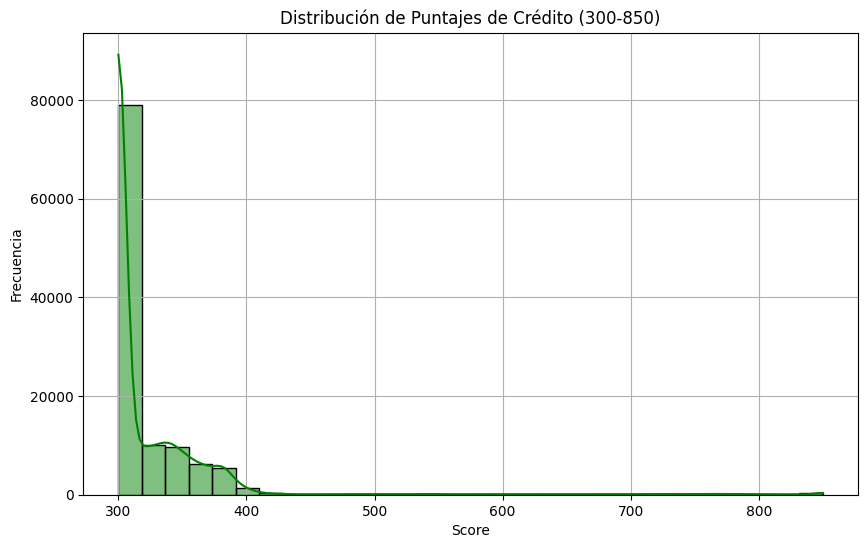

In [14]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [61]:
def probability_to_score_v3(prob, base_score=300, max_score=850, pdo=50, midpoint=0.025, scale=0.5):
    """
    Convierte probabilidades en puntajes de crédito con ajustes para reducir la concentración en los extremos.
    
    Args:
        prob (float): Probabilidad de default.
        base_score (int): Puntaje base (ej. 300).
        max_score (int): Puntaje máximo (ej. 850).
        pdo (int): Puntos para doblar las probabilidades.
        midpoint (float): Punto de inflexión para la transformación logística.
        scale (float): Escala de la transformación logística.
    
    Returns:
        score (float): Puntaje de crédito ajustado al rango.
    """
    # Clipping para evitar problemas numéricos
    prob = np.clip(prob, 1e-6, 1 - 1e-6)
    
    # Transformación logística para una distribución más uniforme
    transformed_prob = 1 / (1 + np.exp(-(np.log(prob / (1 - prob)) - np.log(midpoint / (1 - midpoint))) / scale))
    
    # Calcular odds con la probabilidad transformada
    odds = (1 - transformed_prob) / transformed_prob
    
    # Calcular factor y offset
    factor = pdo / np.log(2)
    offset = base_score + (max_score - base_score) / 2  # Centrar el rango
    
    # Calcular puntaje crudo
    raw_score = offset - factor * np.log(odds)
    
    # Normalizar el puntaje dentro del rango [base_score, max_score]
    score = np.clip(raw_score, base_score, max_score)
    
    return score


In [62]:
# Convertir probabilidades a puntajes
y_scores = np.array([probability_to_score_v3(p) for p in y_pred_proba])

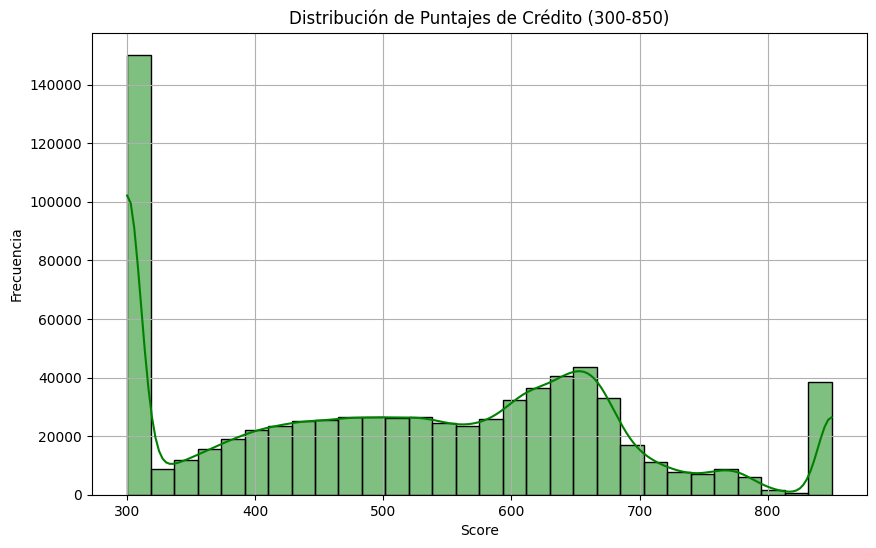

In [63]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()


In [64]:
joblib.dump(y_scores, os.path.join('..', 'data', 'output', 'loan_scores.pkl'))

['..\\data\\output\\loan_scores.pkl']

In [65]:
y_scores = joblib.load(os.path.join('..', 'data', 'output', 'loan_scores.pkl'))

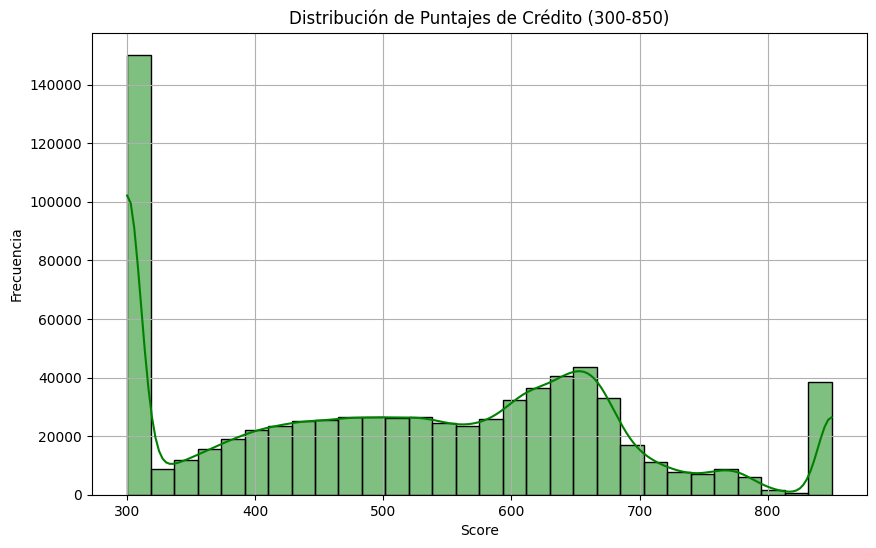

In [66]:
# Visualizar la distribución de los puntajes
plt.figure(figsize=(10, 6))
sns.histplot(y_scores, bins=30, kde=True, color='green')
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid()
plt.show()

In [67]:
test_point = 400

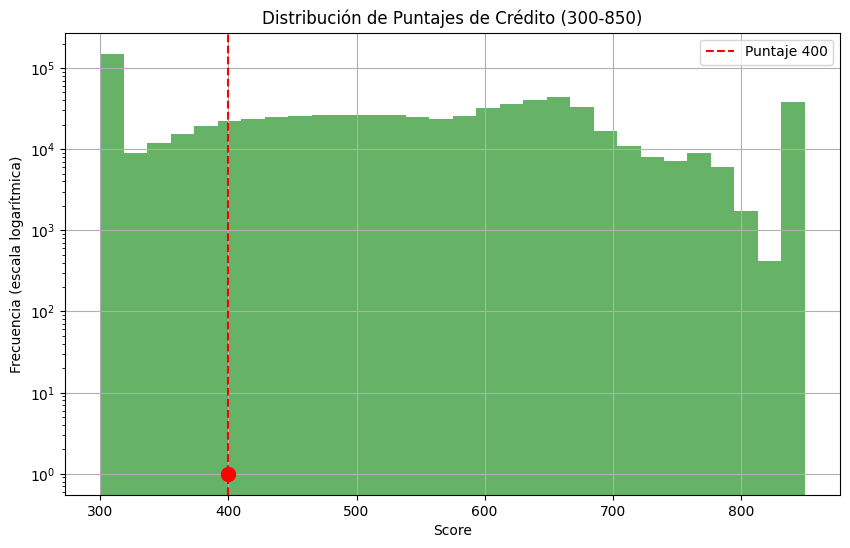

In [68]:
# Visualizar la distribución de los puntajes con escala logarítmica
plt.figure(figsize=(10, 6))
plt.hist(y_scores, bins=30, color='green', alpha=0.6)
plt.yscale('log')
plt.axvline(x=test_point, color='red', linestyle='--', label=f'Puntaje {test_point}')
plt.scatter(test_point, 1, color='red', s=100, zorder=5)
plt.title("Distribución de Puntajes de Crédito (300-850)")
plt.xlabel("Score")
plt.ylabel("Frecuencia (escala logarítmica)")
plt.grid(True)
plt.legend()
plt.show()


In [69]:
def plot_credit_score_distribution(scores, point):
	plt.figure(figsize=(10, 6))
	plt.hist(scores, bins=30, color='green', alpha=0.6)
	plt.yscale('log')
	plt.axvline(x=point, color='red', linestyle='--', label=f'Puntaje {point}')
	plt.scatter(point, 1, color='red', s=100, zorder=5)
	plt.title("Distribución de Puntajes de Crédito (300-850)")
	plt.xlabel("Puntaje")
	plt.ylabel("Frecuencia (escala logarítmica)")
	plt.grid(True)
	plt.legend()
	plt.show()

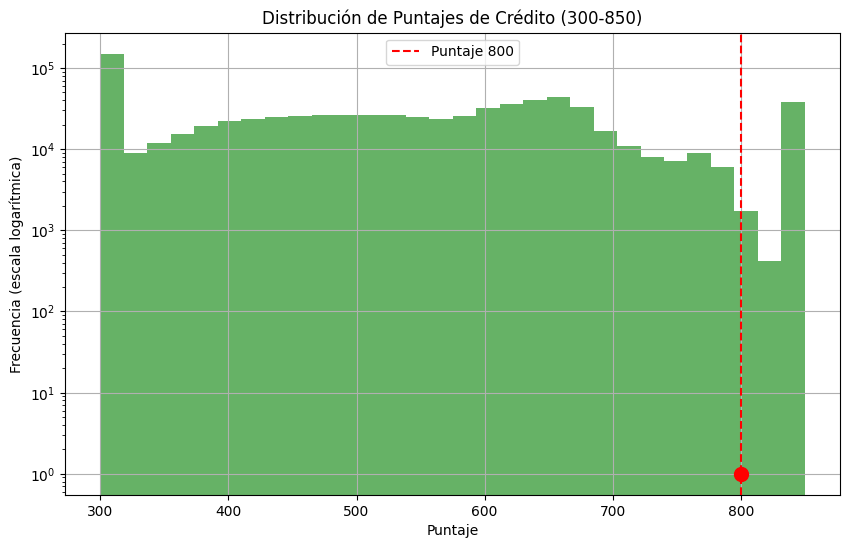

In [70]:
plot_credit_score_distribution(y_scores, 800)